<a href="https://colab.research.google.com/github/gthom73/MLIntegration_project4_group2/blob/main/machineLearningGroup2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!conda install -c pyviz hvplot -y

Retrieving notices: ...working... done
Channels:
 - pyviz
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - hvplot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.11            |       hd590300_1         542 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    bokeh-3.4.1                |     pyhd8ed1ab_0         4.5 MB  conda-forge
    colorcet-3.1.0             |             py_0         445 KB  pyviz
    conda-24.4.0               |  py310hff52083_0         930 KB  conda-forge
    dbus-1.13.6                |       h5008d03_3         604 KB  conda-forge
    gettext-0.22.5             |       h59595ed_2         464 KB  conda-forge
    gettext-tools-0.22.5       |       h59595ed_2         2.6 MB  c

In [3]:
import numpy as np # linear algebra
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

import hvplot.pandas
import tensorflow as tf

import warnings # quiet python warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv") # read in csv data from kaggle 

2024-05-06 22:21:37.488105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 22:21:37.488344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 22:21:37.666371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/usa-real-estate-dataset/realtor-data.zip.csv


In [4]:
# List of cities to filter by
cities = ['Kansas City', 'Topeka', 'Denver', 'Dallas']

# Dictionary to map cities to their respective states (Kansas City can be in Missouri or Kansas)
city_states = {
    'Kansas City': ['Missouri', 'Kansas'],  # Kansas City can be in Missouri or Kansas
    'Topeka': ['Kansas'],
    'Denver': ['Colorado'],
    'Dallas': ['Texas']
}

# Loop through each city and display the first 5 rows for that city in the correct state(s)
for city, states in city_states.items():
    # Filter the DataFrame for the city and check if it's in one of the correct states
    filtered_df = df[(df['city'] == city) & (df['state'].isin(states))]

    # Check if the filtered dataframe is empty
    if not filtered_df.empty:
        print(f"First 5 rows for {city}, States: {', '.join(states)}:")
        print(filtered_df.head(5))
    else:
        print(f"No data available for {city} in {', '.join(states)}")

First 5 rows for Kansas City, States: Missouri, Kansas:
        brokered_by    status     price  bed  bath  acre_lot     street  \
914988        322.0  for_sale  372000.0  4.0   3.0      0.19  1614471.0   
914989      58270.0  for_sale   25000.0  3.0   2.0      0.35   144563.0   
914990      84610.0  for_sale   69950.0  2.0   1.0      0.19  1648065.0   
914994      33478.0  for_sale  109000.0  2.0   3.0      0.07  1747899.0   
915001      20177.0  for_sale  137500.0  4.0   1.0      0.23  1740406.0   

               city     state  zip_code  house_size prev_sold_date  
914988  Kansas City  Missouri   64158.0      2300.0     2016-09-09  
914989  Kansas City  Missouri   64133.0      1884.0     2004-03-22  
914990  Kansas City  Missouri   64129.0      1134.0            NaN  
914994  Kansas City  Missouri   64134.0      2062.0     2005-01-13  
915001  Kansas City  Missouri   64134.0       912.0     2008-02-06  
First 5 rows for Topeka, States: Kansas:
        brokered_by    status     pric

In [5]:
# List of cities to analyze
cities = ['Kansas City', 'Topeka', 'Denver', 'Dallas']

# Filter the DataFrame for these cities
filtered_df = df[df['city'].isin(cities)]

# Group by city and number of bedrooms, then calculate count and mean price
result = filtered_df.groupby(['city', 'bed']).agg(
    Houses_Available=('price', 'count'),
    Average_Price=('price', 'mean')
).reset_index()

# Format the Average Price to be more readable
result['Average_Price'] = result['Average_Price'].round(2)

print(result)

           city    bed  Houses_Available  Average_Price
0        Dallas    1.0               413      228606.82
1        Dallas    2.0              1588      399111.65
2        Dallas    3.0              3399      474756.44
3        Dallas    4.0              1938      698018.75
4        Dallas    5.0               483     1382225.59
5        Dallas    6.0                86     2103946.91
6        Dallas    7.0                10     5322690.00
7        Dallas    8.0                16     2841325.00
8        Dallas    9.0                 2     8525000.00
9        Dallas   10.0                 1     1597500.00
10       Dallas   14.0                 2     1029500.00
11       Dallas   23.0                 1      680000.00
12       Dallas   28.0                 1     3975000.00
13       Dallas   62.0                 1     6500000.00
14       Dallas  222.0                 1      699000.00
15       Denver    1.0               277      442537.16
16       Denver    2.0               717      56

In [6]:
# List of cities to analyze and their acceptable states
city_states = {
    'Kansas City': ['Missouri', 'Kansas'],  # Kansas City can be in Missouri or Kansas
    'Topeka': ['Kansas'],
    'Denver': ['Colorado'],
    'Dallas': ['Texas']
}

# Convert city_states dictionary to a DataFrame for easier filtering
cities_df = pd.DataFrame([(city, state) for city, states in city_states.items() for state in states], columns=['city', 'state'])

# Merge the cities DataFrame with the main DataFrame to filter correctly by city and state
filtered_df = pd.merge(df, cities_df, on=['city', 'state'])

# Further filter the DataFrame to ensure the number of bedrooms is 5 or less
filtered_df = filtered_df[filtered_df['bed'] <= 5]

# Group by city, state, and number of bedrooms ('bed'), then calculate count and mean price
result = filtered_df.groupby(['city', 'state', 'bed']).agg(
    Houses_Available=('price', 'count'),
    Average_Price=('price', 'mean')
).reset_index()

# Format the Average Price to be more readable
result['Average_Price'] = result['Average_Price'].round(2)

# Display the results
print(result)

           city     state  bed  Houses_Available  Average_Price
0        Dallas     Texas  1.0               411      229210.99
1        Dallas     Texas  2.0              1518      404114.66
2        Dallas     Texas  3.0              2964      490675.12
3        Dallas     Texas  4.0              1625      756389.96
4        Dallas     Texas  5.0               368     1664239.68
5        Denver  Colorado  1.0               276      441501.78
6        Denver  Colorado  2.0               675      573979.85
7        Denver  Colorado  3.0               663      705512.41
8        Denver  Colorado  4.0               454      979627.41
9        Denver  Colorado  5.0               172     1611204.88
10  Kansas City    Kansas  1.0                 2      152500.00
11  Kansas City    Kansas  2.0                79      171958.86
12  Kansas City    Kansas  3.0               149      211580.23
13  Kansas City    Kansas  4.0                66      478251.41
14  Kansas City    Kansas  5.0          

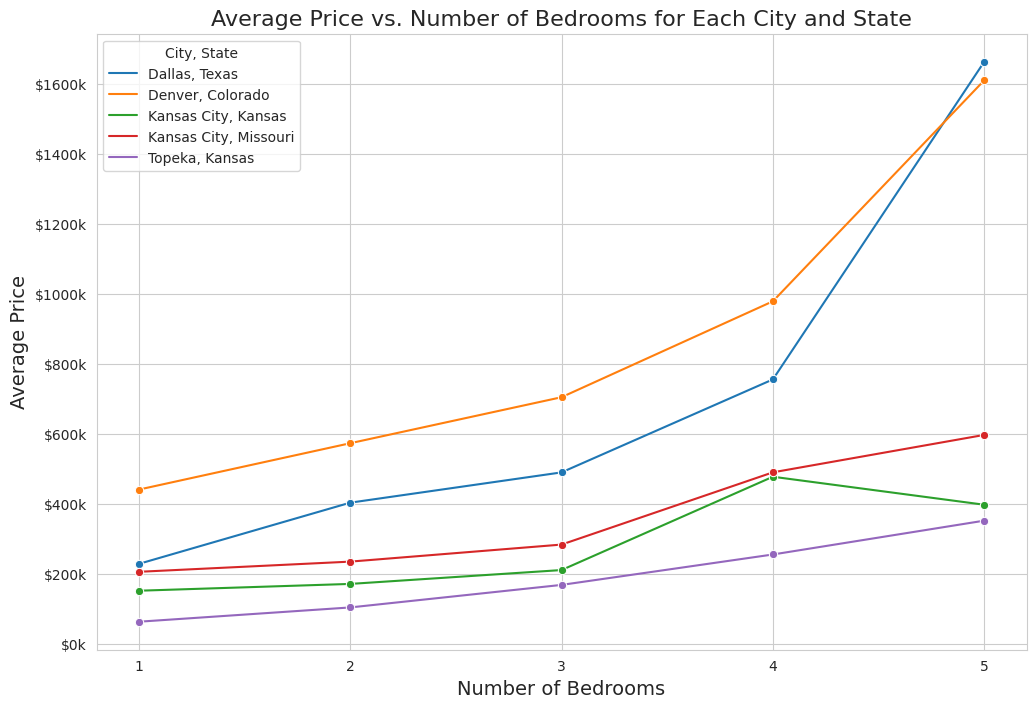

In [7]:


# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a new column 'City_State' combining city and state for clearer labeling in the graph
result['City_State'] = result['city'] + ', ' + result['state']

# Create a line plot
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=result, x='bed', y='Average_Price', hue='City_State', marker='o')

# Adding titles and labels
plt.title('Average Price vs. Number of Bedrooms for Each City and State', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(result['bed'].unique())  # Ensure all bedroom categories are shown

# Format the y-axis to show dollar sign and the value
lineplot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${int(x/1000)}k'))

# Enhance the legend for better clarity
plt.legend(title='City, State')
plt.show()

In [8]:
# Remove rows with Nan values
filtered_df = filtered_df.dropna()

# Create a new column 'City_State' combining city and state for clearer labeling in the graph
filtered_df['City_State'] = filtered_df['city'] + ', ' + filtered_df['state']

# Create a new column for per sqr/ft 
filtered_df['pr_sqr_ft'] = filtered_df['price'] / filtered_df['house_size']

# Display data
filtered_df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,City_State,pr_sqr_ft
0,322.0,for_sale,372000.0,4.0,3.0,0.19,1614471.0,Kansas City,Missouri,64158.0,2300.0,2016-09-09,"Kansas City, Missouri",161.739130
1,58270.0,for_sale,25000.0,3.0,2.0,0.35,144563.0,Kansas City,Missouri,64133.0,1884.0,2004-03-22,"Kansas City, Missouri",13.269639
3,33478.0,for_sale,109000.0,2.0,3.0,0.07,1747899.0,Kansas City,Missouri,64134.0,2062.0,2005-01-13,"Kansas City, Missouri",52.861300
4,20177.0,for_sale,137500.0,4.0,1.0,0.23,1740406.0,Kansas City,Missouri,64134.0,912.0,2008-02-06,"Kansas City, Missouri",150.767544
8,81753.0,for_sale,115000.0,3.0,2.0,0.26,1828543.0,Kansas City,Missouri,64134.0,1227.0,1997-09-30,"Kansas City, Missouri",93.724531


In [9]:
# Splitting based on city
grouped = filtered_df.groupby('City_State')

topeka_group_df = pd.DataFrame(grouped.get_group('Topeka, Kansas'))
kcmo_group_df = pd.DataFrame(grouped.get_group('Kansas City, Missouri'))
kcks_group_df = pd.DataFrame(grouped.get_group('Kansas City, Kansas'))
dallas_group_df = pd.DataFrame(grouped.get_group('Dallas, Texas'))
denver_group_df = pd.DataFrame(grouped.get_group('Denver, Colorado'))

# Example prediction for a house with 2000 sqft, 4 rooms, and zip code 80202
X_prediction = pd.DataFrame([[2000, 4, 66102]], columns=['pr_sqr_ft', 'bed', 'zip_code'])  # Create DataFrame for prediction

# topeka_group_df
# kcmo_group_df
kcks_group_df
# dallas_group_df
# denver_group_df


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,City_State,pr_sqr_ft
685,17097.0,for_sale,205000.0,2.0,2.0,0.61,1265807.0,Kansas City,Kansas,66106.0,2472.0,1988-02-01,"Kansas City, Kansas",82.928803
744,90303.0,for_sale,170000.0,3.0,1.0,0.27,1317035.0,Kansas City,Kansas,66106.0,1008.0,2022-01-14,"Kansas City, Kansas",168.650794
749,52785.0,for_sale,187000.0,4.0,2.0,0.15,742256.0,Kansas City,Kansas,66103.0,1388.0,2004-04-28,"Kansas City, Kansas",134.726225
757,52787.0,for_sale,275000.0,4.0,3.0,0.20,838154.0,Kansas City,Kansas,66106.0,1600.0,1992-10-01,"Kansas City, Kansas",171.875000
769,84630.0,for_sale,185000.0,2.0,2.0,0.10,452465.0,Kansas City,Kansas,66103.0,1104.0,2018-08-22,"Kansas City, Kansas",167.572464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,84638.0,for_sale,75000.0,2.0,1.0,0.14,24886.0,Kansas City,Kansas,66102.0,979.0,2021-02-01,"Kansas City, Kansas",76.608784
2525,44666.0,for_sale,179000.0,4.0,2.0,0.41,35174.0,Kansas City,Kansas,66111.0,1804.0,2021-09-27,"Kansas City, Kansas",99.223947
2600,75009.0,for_sale,70000.0,2.0,1.0,0.25,871172.0,Kansas City,Kansas,66101.0,1149.0,2018-11-20,"Kansas City, Kansas",60.922541
2654,71242.0,for_sale,297000.0,3.0,3.0,0.23,968836.0,Kansas City,Kansas,66106.0,2166.0,2014-08-20,"Kansas City, Kansas",137.119114


In [10]:
# Preprocessing
# X = topeka_group_df[['pr_sqr_ft', 'bed', 'zip_code']]
# y = topeka_group_df['price']

# X = kcmo_group_df[['pr_sqr_ft', 'bed', 'zip_code']]
# y = kcmo_group_df['price']

X = kcks_group_df[['pr_sqr_ft', 'bed', 'zip_code']]
y = kcks_group_df['price']

# X = dallas_group_df[['pr_sqr_ft', 'bed', 'zip_code']]
# y = dallas_group_df['price']

# X = denver_group_df[['pr_sqr_ft', 'bed', 'zip_code']]
# y = denver_group_df['price']

In [11]:
# Define column transformer for one-hot encoding
column_transformer = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore'), ['zip_code'])],
    remainder='passthrough'
)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error"
}

In [13]:
print("Linear Regression")

# Define the pipeline
pipeline = Pipeline([
    # ('preprocessor', column_transformer),
    ('regressor', LinearRegression())
])

# Training the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mseLR = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.4f}".format(mseLR))

maeLR = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", maeLR)

r_squaredLR = r2_score(y_test, y_pred)
print("R-squared:", r_squaredLR)

predicted_price = pipeline.predict(X_prediction)
print("Predicted Price:", predicted_price)

predictions = pipeline.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)


Linear Regression
Mean Squared Error: 19771800586.0595
Mean Absolute Error: 120079.66147690323
R-squared: 0.18928422302150727
Predicted Price: [7382886.50513358]


,Prediction,Actual
1710,29035.716638,180000.0
1642,232360.957916,119900.0
2249,-231609.600540,80000.0
1958,449778.024780,349000.0
1884,259446.867611,320000.0
1720,379949.859181,205000.0
1671,295407.014924,125000.0
1730,234311.217087,240000.0
2178,127115.370586,250000.0
1601,152581.509506,233000.0


In [14]:
print("Linear Regression - One Hot Encoding")

# Define the pipeline
pipeline_oneHot = Pipeline([
    ('preprocessor', column_transformer),
    ('regressor', LinearRegression())
])

# Training the model
pipeline_oneHot.fit(X_train, y_train)

y_pred = pipeline_oneHot.predict(X_test)
mseLRH = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mseLRH)

maeLRH = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", maeLRH)

r_squaredLRH = r2_score(y_test, y_pred)
print("R-squared:", r_squaredLRH)

predicted_price = pipeline_oneHot.predict(X_prediction)
print("Predicted Price:", predicted_price)

predictions = pipeline_oneHot.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)

Linear Regression - One Hot Encoding
Mean Squared Error: 20422576161.886566
Mean Absolute Error: 119561.18477941473
R-squared: 0.16260005612943007
Predicted Price: [7516549.55382311]


,Prediction,Actual
1710,45642.493239,180000.0
1642,272569.411372,119900.0
2249,-214384.835149,80000.0
1958,451893.385849,349000.0
1884,247791.561865,320000.0
1720,357086.919089,205000.0
1671,299658.364246,125000.0
1730,226637.869809,240000.0
2178,151220.812173,250000.0
1601,139399.761854,233000.0


In [15]:
print("Random Forest")

rclassifier = RandomForestRegressor(n_estimators=500)

# Train the model
rclassifier.fit(X_train, y_train)

y_pred = rclassifier.predict(X_test)
mseRF = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mseRF)

maeRF = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", maeRF)

r_squaredRF = r2_score(y_test, y_pred)
print("R-squared:", r_squaredRF)

predicted_price = rclassifier.predict(X_prediction)
print("Predicted Price:", predicted_price)

predictions = rclassifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)

Random Forest
Mean Squared Error: 10701509227.362473
Mean Absolute Error: 55882.66744186046
R-squared: 0.5611991770632774
Predicted Price: [6842247.2]


,Prediction,Actual
1710,183289.600,180000.0
1642,138896.600,119900.0
2249,102074.800,80000.0
1958,226671.500,349000.0
1884,303625.000,320000.0
1720,210941.874,205000.0
1671,149201.500,125000.0
1730,277402.300,240000.0
2178,232134.600,250000.0
1601,275546.500,233000.0


In [16]:
print("Random Forest - One Hot Encoding")

rclassifier = RandomForestRegressor(n_estimators=500)

# Define the pipeline
pipeline_rf_hot = Pipeline([
    ('preprocessor', column_transformer),
    ('regressor', rclassifier)
])

# Train the model
pipeline_rf_hot.fit(X_train, y_train)

y_pred = pipeline_rf_hot.predict(X_test)
mse_rf_hot = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mseRF)

mae_rf_hot = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", maeRF)

r_squared_rf_hot = r2_score(y_test, y_pred)
print("R-squared:", r_squaredRF)

predicted_price = pipeline_rf_hot.predict(X_prediction)
print("Predicted Price:", predicted_price)

predictions = pipeline_rf_hot.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)

print(y_train)

Random Forest - One Hot Encoding
Mean Squared Error: 10701509227.362473
Mean Absolute Error: 55882.66744186046
R-squared: 0.5611991770632774
Predicted Price: [6634784.1]
1664    189500.0
1921    149000.0
1758    209500.0
1802    210000.0
1715    245000.0
          ...   
1751    235000.0
895     130000.0
1697     28000.0
2058    381440.0
1735    190000.0
Name: price, Length: 170, dtype: float64


In [17]:
print("Gradient Boosting Regressor")

gclassifier = GradientBoostingRegressor(**params)
gclassifier.fit(X_train, y_train)

y_pred = gclassifier.predict(X_test)
mseGB = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mseGB)

maeGB = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", maeGB)

r_squaredGB = r2_score(y_test, y_pred)
print("R-squared:", r_squaredGB)

predicted_price =gclassifier.predict(X_prediction)
print("Predicted Price:", predicted_price)

predictions = gclassifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)

Gradient Boosting Regressor
Mean Squared Error: 12081203687.31975
Mean Absolute Error: 63253.86790542905
R-squared: 0.5046266832618864
Predicted Price: [9936176.41315865]


,Prediction,Actual
1710,165759.749317,180000.0
1642,136938.572762,119900.0
2249,89559.646050,80000.0
1958,208628.882527,349000.0
1884,294042.281979,320000.0
1720,211557.679552,205000.0
1671,174067.310277,125000.0
1730,297771.658835,240000.0
2178,208880.930775,250000.0
1601,287327.686023,233000.0


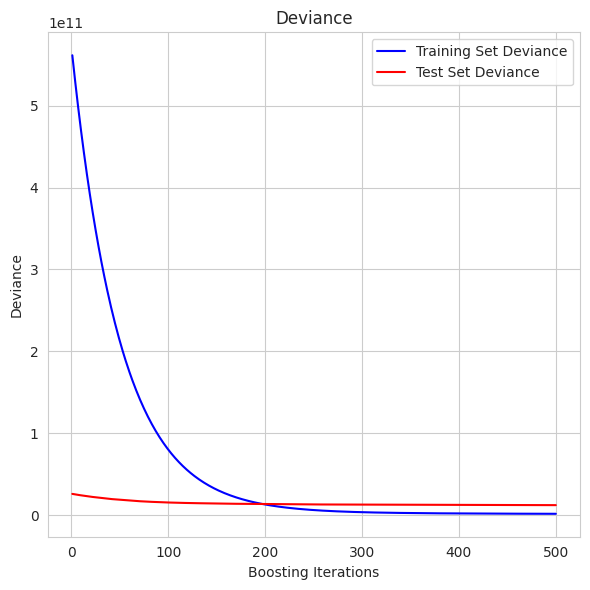

In [22]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gclassifier.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gclassifier.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

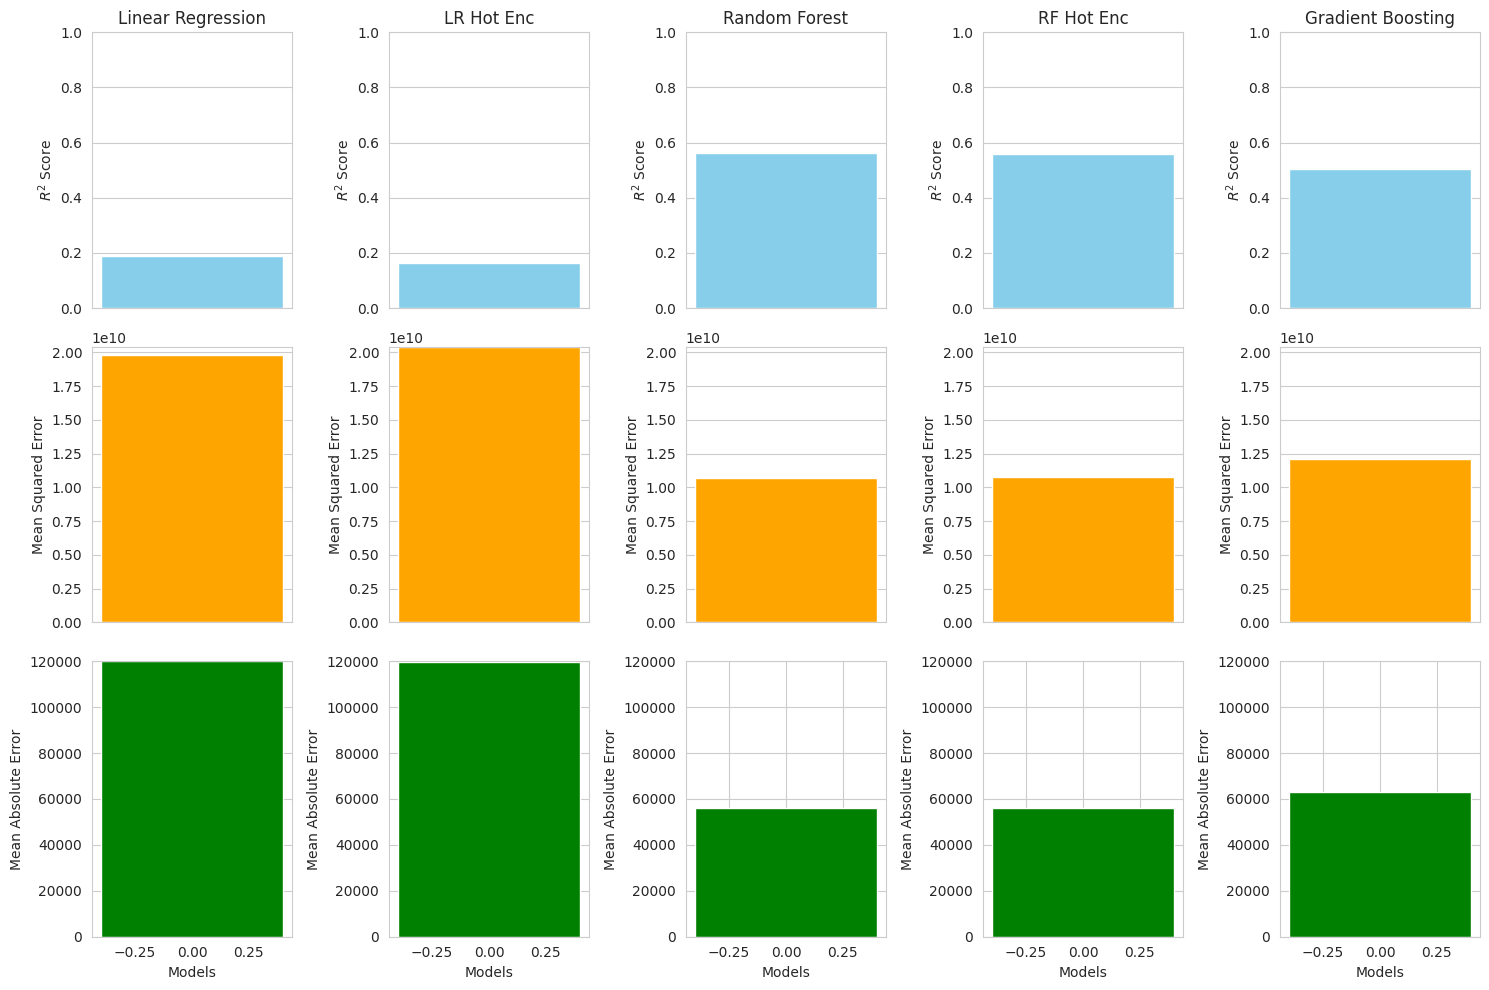

In [18]:
import matplotlib.pyplot as plt

# Example data for R-squared scores, mean squared errors, and mean absolute errors
r2_scores = [r_squaredLR, r_squaredLRH, r_squaredRF, r_squared_rf_hot, r_squaredGB]
mean_squared_errors = [mseLR, mseLRH, mseRF, mse_rf_hot, mseGB]
mean_absolute_errors = [maeLR, maeLRH, maeRF, mae_rf_hot, maeGB]

# Model names or labels
model_names = ['Linear Regression', 'LR Hot Enc', 'Random Forest', 'RF Hot Enc', 'Gradient Boosting']

# Create a grid layout with 3 rows and 5 columns
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Plotting R-squared scores
for i, (ax, r2score, model_name) in enumerate(zip(axs[0], r2_scores, model_names)):
    ax.bar([0], [r2score], color='skyblue')
    ax.set_title(model_name)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel('$R^2$ Score')

# Plotting mean squared errors
for i, (ax, mse) in enumerate(zip(axs[1], mean_squared_errors)):
    ax.bar([0], [mse], color='orange')
    ax.set_ylim(0, max(mean_squared_errors) + 20)
    ax.set_xticks([])
    ax.set_ylabel('Mean Squared Error')

# Plotting mean absolute errors
for i, (ax, mae) in enumerate(zip(axs[2], mean_absolute_errors)):
    ax.bar([0], [mae], color='green')
    ax.set_ylim(0, max(mean_absolute_errors) + 2)
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Models')

# Adjust layout
plt.tight_layout()
plt.show()
